## Build LinerModel

In [1]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
tf.enable_eager_execution()

In [4]:
! pip install -q requests
! git clone --depth 1 https://github.com/tensorflow/models

You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Cloning into 'models'...
remote: Enumerating objects: 3050, done.
remote: Counting objects: 100% (3050/3050), done.
remote: Compressing objects: 100% (2567/2567), done.
remote: Total 3050 (delta 541), reused 2038 (delta 406), pack-reused 0
Receiving objects: 100% (3050/3050), 370.25 MiB | 4.53 MiB/s, done.
Resolving deltas: 100% (541/541), done.
Checking out files: 100% (2883/2883), done.


In [5]:
models_path = os.path.join(os.getcwd(), 'models')

sys.path.append(models_path)

In [ ]:
# from official.wide_deep import census_dataset
# from official.wide_deep import census_main

# census_dataset.download("/tmp/census_data/")

## Boosted Tree

In [9]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 2.7MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [10]:
!pip3 install -q tf-nightly  # Requires tf 1.13

In [11]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [13]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [14]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


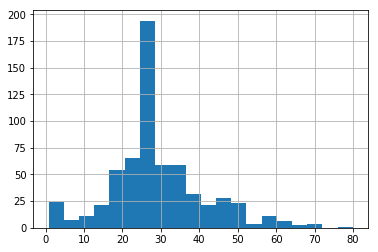

In [15]:
dftrain.age.hist(bins=20)

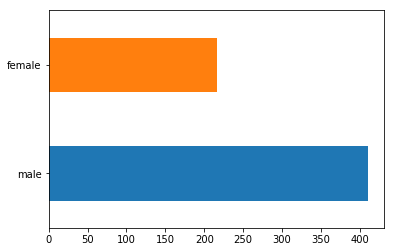

In [16]:
dftrain.sex.value_counts().plot(kind='barh')

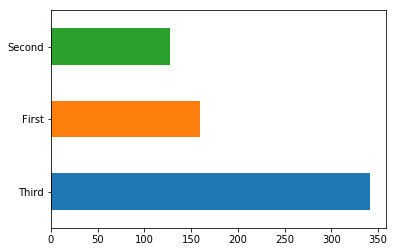

In [17]:
(dftrain['class'].value_counts().plot(kind='barh'))

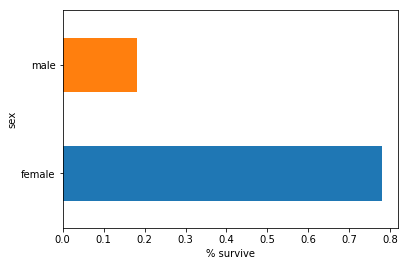

In [19]:
ax = (pd.concat([dftrain, y_train], axis=1)\
  .groupby('sex')
  .survived
  .mean()
  .plot(kind='barh'))
ax.set_xlabel('% survive');

In [20]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [21]:
def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name, vocab)
    )

In [22]:
feature_columns=[]
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

In [25]:
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [30]:
feature_columns

[_IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='e

In [31]:
example = dftrain.head(1)
class_fc = one_hot_cat_column('class', ('First', 'Second', 'Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', fc.input_layer(dict(example), [class_fc]).numpy())

Feature value: "Third"


IndexError: list index out of range

In [36]:
fc.input_layer(dict(example), feature_columns).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [37]:
NUM_EXAMPLES = len(y_train)

In [51]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs)  
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

In [52]:
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [53]:
linear_est = tf.estimator.LinearClassifier(feature_columns)
linear_est.train(train_input_fn, max_steps=100)

In [54]:
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.78409094
Dummy model:  0.625


In [56]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

ValueError: For now, only bucketized_column and indicator_column is supported but got: _NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

## Boosted Trees Understanding